In [3]:
!pip install scikit-image --quiet


In [1]:
import os
import numpy as np
from torchvision.datasets import STL10
from PIL import Image

def to_grayscale(img):
    return img.convert("L").convert("RGB")

def generate_altered_stl10(root='./data', out_root='./altered_data'):
    os.makedirs(out_root, exist_ok=True)
    
    trainset = STL10(root=root, split='train', download=True)
    testset = STL10(root=root, split='test', download=True)

    print("Generating train set (original only)...")
    for idx, (img, label) in enumerate(trainset):
        class_dir = os.path.join(out_root, "train", str(label))
        os.makedirs(class_dir, exist_ok=True)
        img.save(os.path.join(class_dir, f"{idx}.png"))
        if idx % 500 == 0:
            print(f"[train] {idx}/{len(trainset)}")

    print("Generating test sets (original, grayscale)...")
    for idx, (img, label) in enumerate(testset):
        for version in ["original", "grayscale"]:
            class_dir = os.path.join(out_root, "test", version, str(label))
            os.makedirs(class_dir, exist_ok=True)

        orig_path = os.path.join(out_root, "test", "original", str(label), f"{idx}.png")
        img.save(orig_path)

        gray_path = os.path.join(out_root, "test", "grayscale", str(label), f"{idx}.png")
        gray_img = to_grayscale(img)
        gray_img.save(gray_path)

        if idx % 500 == 0:
            print(f"[test] {idx}/{len(testset)}")

    print("Done. Data saved under:", out_root)


generate_altered_stl10()


100%|██████████| 2.64G/2.64G [05:29<00:00, 8.01MB/s] 


Generating train set (original only)...
[train] 0/5000
[train] 500/5000
[train] 1000/5000
[train] 1500/5000
[train] 2000/5000
[train] 2500/5000
[train] 3000/5000
[train] 3500/5000
[train] 4000/5000
[train] 4500/5000
Generating test sets (original, grayscale)...
[test] 0/8000
[test] 500/8000
[test] 1000/8000
[test] 1500/8000
[test] 2000/8000
[test] 2500/8000
[test] 3000/8000
[test] 3500/8000
[test] 4000/8000
[test] 4500/8000
[test] 5000/8000
[test] 5500/8000
[test] 6000/8000
[test] 6500/8000
[test] 7000/8000
[test] 7500/8000
Done. Data saved under: ./altered_data


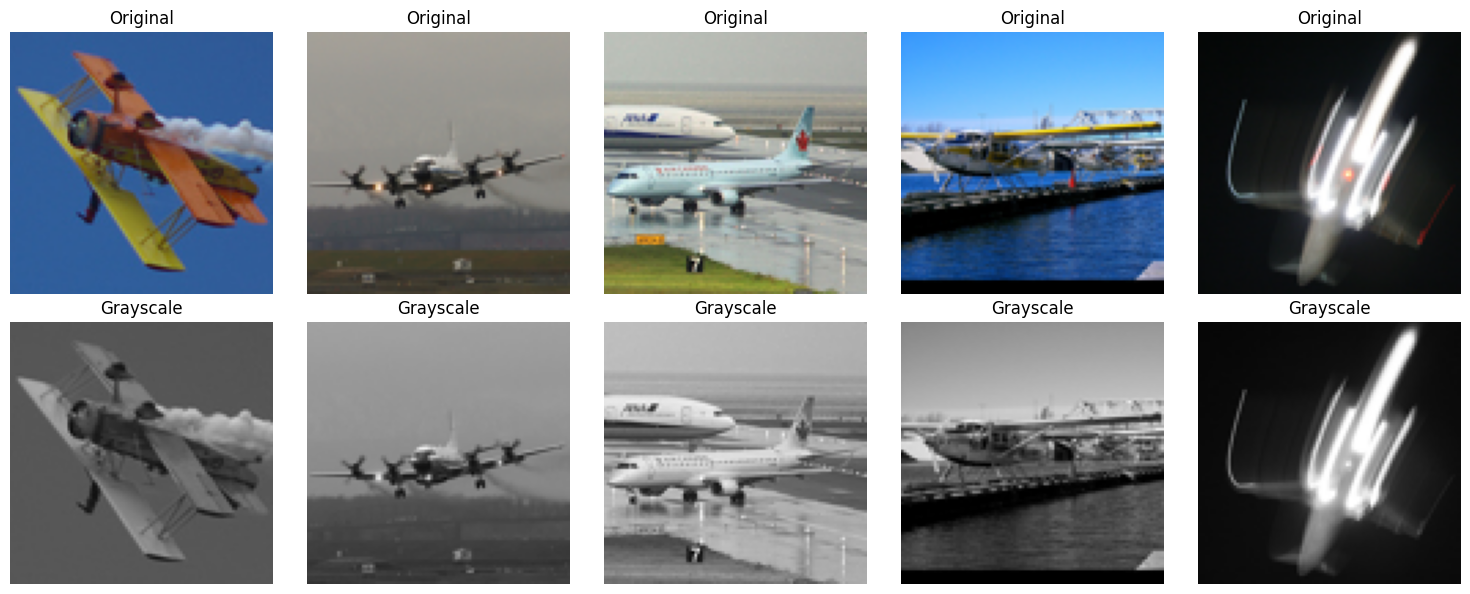

In [3]:
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os

orig_samples = sorted(glob('/kaggle/working/altered_data/test/original/0/*.png'))[:5]
gray_samples = sorted(glob('/kaggle/working/altered_data/test/grayscale/0/*.png'))[:5]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    if i < len(orig_samples):
        img = Image.open(orig_samples[i]).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

    if i < len(gray_samples):
        img = Image.open(gray_samples[i])
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title("Grayscale")

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Using device: cuda


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_tfms_resnet = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_tfms_resnet = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.ImageFolder(root='./altered_data/train', transform=train_tfms_resnet)
testset  = datasets.ImageFolder(root='./altered_data/test/original', transform=test_tfms_resnet)

val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

num_classes = len(trainset.classes)
print("Classes:", num_classes)




Classes: 10


In [6]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

    return model, train_accs, val_accs


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


TRAINING AND ACCUCARIES ON ORIGINAL TEST DATA


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Epoch 1: Train Acc=0.804, Val Acc=0.916


Epoch 2: Train Acc=0.957, Val Acc=0.904


Epoch 3: Train Acc=0.983, Val Acc=0.908


Epoch 4: Train Acc=0.990, Val Acc=0.928


Epoch 5: Train Acc=0.996, Val Acc=0.922


Epoch 6: Train Acc=0.993, Val Acc=0.922


Epoch 7: Train Acc=0.995, Val Acc=0.910


Epoch 8: Train Acc=0.997, Val Acc=0.918


Epoch 9: Train Acc=0.994, Val Acc=0.916


Epoch 10: Train Acc=0.996, Val Acc=0.910


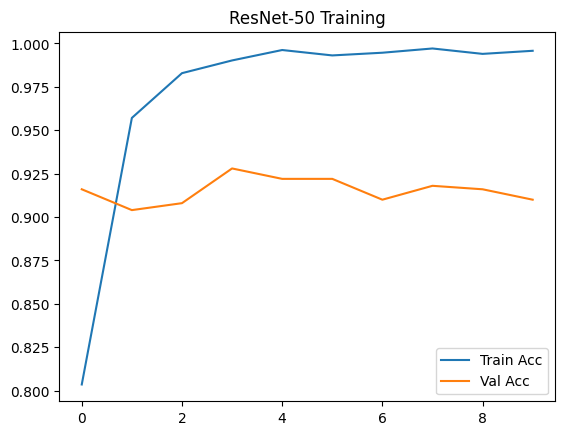

In [7]:
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet, res_train_accs, res_val_accs = train_model(resnet, train_loader, val_loader, epochs=10, lr=1e-4)

plt.plot(res_train_accs, label="Train Acc")
plt.plot(res_val_accs, label="Val Acc")
plt.title("ResNet-50 Training")
plt.legend()
plt.show()



In [8]:
res_test_acc = evaluate(resnet, test_loader)
print(f"ResNet-50 Test Accuracy (Original): {res_test_acc:.3f}")

ResNet-50 Test Accuracy (Original): 0.917


In [9]:
train_tfms_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_tfms_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_vit = datasets.ImageFolder(root="./altered_data/train", transform=train_tfms_vit)
val_size = int(0.1 * len(trainset_vit))
train_size = len(trainset_vit) - val_size
train_subset_vit, val_subset_vit = random_split(trainset_vit, [train_size, val_size])

train_loader_vit = DataLoader(train_subset_vit, batch_size=64, shuffle=True, num_workers=2)
val_loader_vit   = DataLoader(val_subset_vit, batch_size=64, shuffle=False, num_workers=2)

testset_vit = datasets.ImageFolder(root="./altered_data/test/original", transform=test_tfms_vit)
test_loader_vit = DataLoader(testset_vit, batch_size=128, shuffle=False, num_workers=2)


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1: Train Acc=0.927, Val Acc=0.980


Epoch 2: Train Acc=0.993, Val Acc=0.956


Epoch 3: Train Acc=0.997, Val Acc=0.964


Epoch 4: Train Acc=0.998, Val Acc=0.984


Epoch 5: Train Acc=1.000, Val Acc=0.976


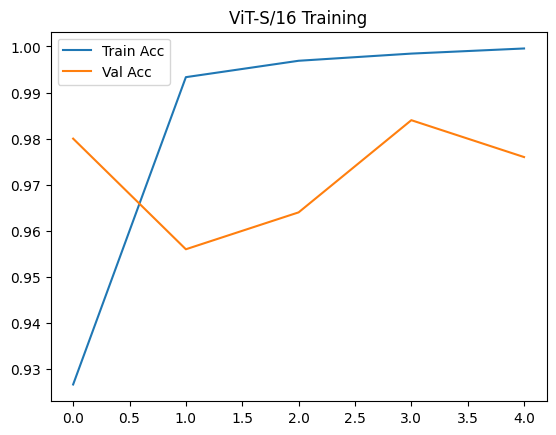

In [10]:
vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
vit = vit.to(device)

vit, vit_train_accs, vit_val_accs = train_model(vit, train_loader_vit, val_loader_vit, epochs=5, lr=1e-4)

plt.plot(vit_train_accs, label="Train Acc")
plt.plot(vit_val_accs, label="Val Acc")
plt.title("ViT-S/16 Training")
plt.legend()
plt.show()

In [11]:
vit_test_acc = evaluate(vit, test_loader_vit)
print(f"ViT-S/16 Test Accuracy (Original): {vit_test_acc:.3f}")

ViT-S/16 Test Accuracy (Original): 0.983


COLOUR BIAS

In [12]:
gray_test_transform_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset_gray_resnet = datasets.ImageFolder(
    root="./altered_data/test/grayscale", 
    transform=gray_test_transform_resnet
)
test_loader_gray_resnet = DataLoader(testset_gray_resnet, batch_size=256, shuffle=False, num_workers=2)

res_gray_acc = evaluate(resnet, test_loader_gray_resnet)
print(f"ResNet-50 Test Accuracy (Grayscale): {res_gray_acc:.3f}")

ResNet-50 Test Accuracy (Grayscale): 0.846


In [13]:
gray_test_transform_vit = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset_gray_vit = datasets.ImageFolder(
    root="./altered_data/test/grayscale",
    transform=gray_test_transform_vit
)
test_loader_gray_vit = DataLoader(testset_gray_vit, batch_size=128, shuffle=False, num_workers=2)

vit_gray_acc = evaluate(vit, test_loader_gray_vit)
print(f"ViT-S/16 Test Accuracy (Grayscale): {vit_gray_acc:.3f}")

ViT-S/16 Test Accuracy (Grayscale): 0.959


In [14]:
print("\n--- Color Bias Test ---")
print(f"ResNet-50 Drop: {res_test_acc - res_gray_acc:.3f}")
print(f"ViT-S/16 Drop: {vit_test_acc - vit_gray_acc:.3f}")


--- Color Bias Test ---
ResNet-50 Drop: 0.071
ViT-S/16 Drop: 0.024


SHAPE AND TEXTURE BIAS TEST


In [4]:
import os
import shutil

content_dir = '/kaggle/working/content/'
os.makedirs(content_dir, exist_ok=True)

original_dir = '/kaggle/working/altered_data/test/original' 

for subfolder in sorted(os.listdir(original_dir)):
    sub_path = os.path.join(original_dir, subfolder)
    for img_file in os.listdir(sub_path):
        src = os.path.join(sub_path, img_file)
        dst = os.path.join(content_dir, f"{subfolder}_{img_file}") 
        shutil.copy(src, dst)


In [5]:
!git clone https://github.com/naoto0804/pytorch-AdaIN.git
%cd pytorch-AdaIN
!pip install -r requirements.txt


Cloning into 'pytorch-AdaIN'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 344 (delta 71), reused 60 (delta 60), pack-reused 264 (from 3)
Receiving objects: 100% (344/344), 7.80 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/kaggle/working/pytorch-AdaIN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.1 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement pkg-resources==0.0.0 (from versions: none)
ERROR: No matching distribution 

In [6]:
!python test.py \
--content_dir /kaggle/working/content \
--style input/style/asheville.jpg \
--content_size 256 \
--style_size 256 \
--preserve_color \
--alpha 0.5 \
--crop\
--decoder /kaggle/input/new-decoder/decoder_iter_160000.pth \
--vgg /kaggle/input/decoder-my/vgg_normalised.pth


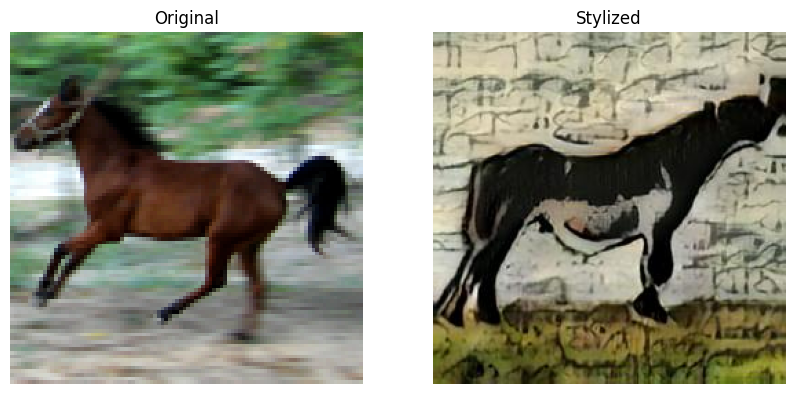

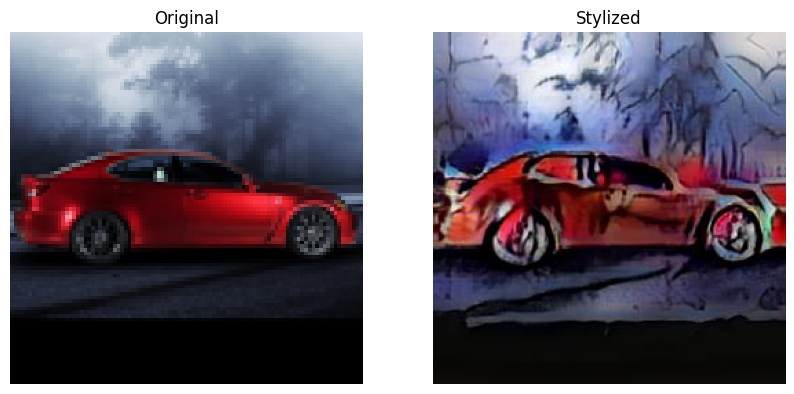

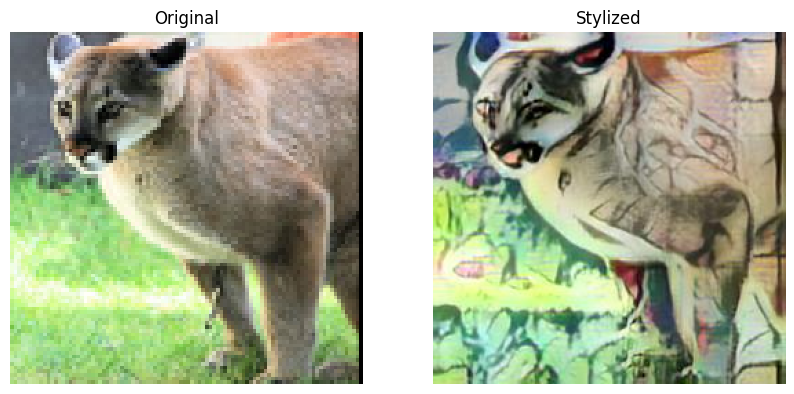

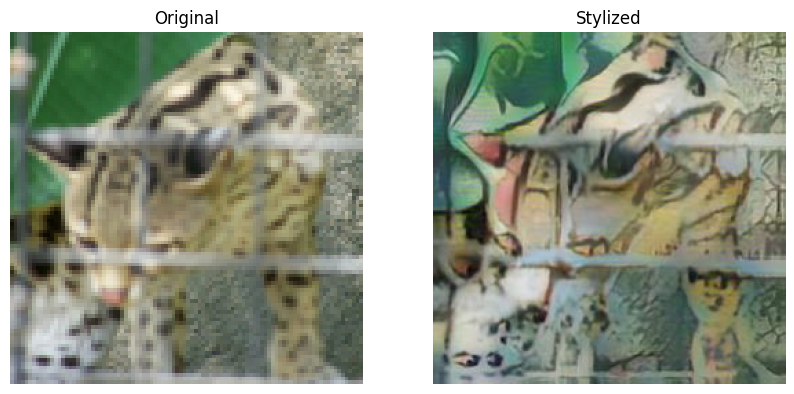

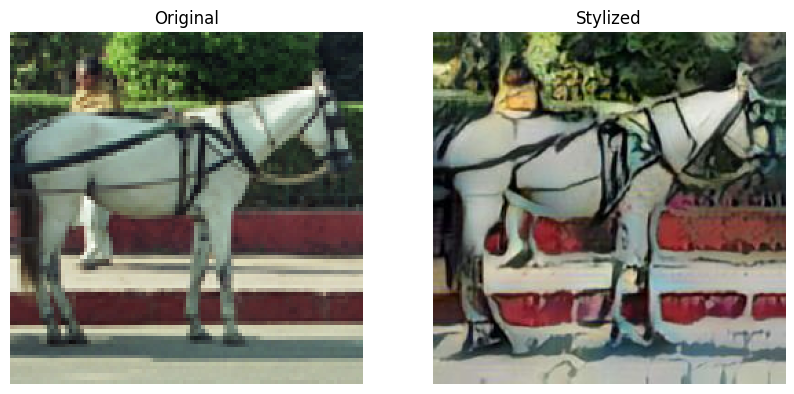

In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

content_dir = '/kaggle/working/content/' 
output_dir = '/kaggle/working/pytorch-AdaIN/output/'  

content_files = sorted([f for f in os.listdir(content_dir) if f.endswith(('.png', '.jpg'))])
output_files = sorted([f for f in os.listdir(output_dir) if f.endswith(('.png', '.jpg'))])

random_indices = random.sample(range(len(content_files)), 5)

for idx in random_indices:
    orig_file = content_files[idx]
    stylized_file = output_files[idx]
    
    orig_img = Image.open(os.path.join(content_dir, orig_file))
    stylized_img = Image.open(os.path.join(output_dir, stylized_file))
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(stylized_img)
    plt.title("Stylized")
    plt.axis('off')
    
    plt.show()


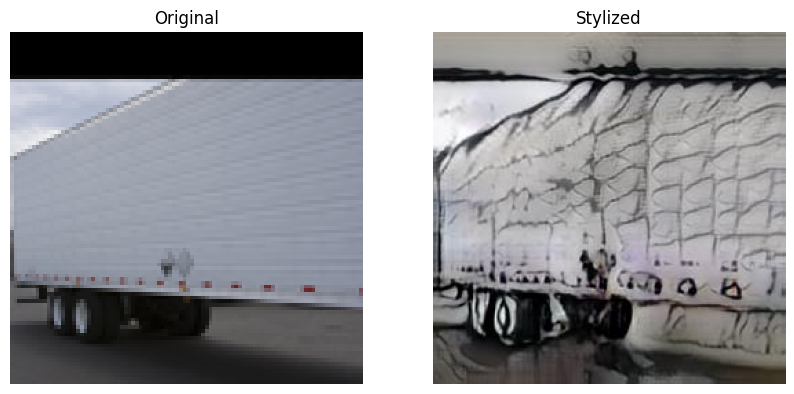

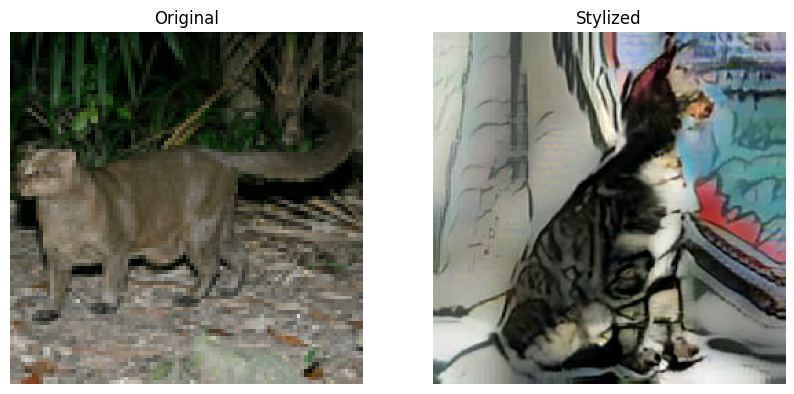

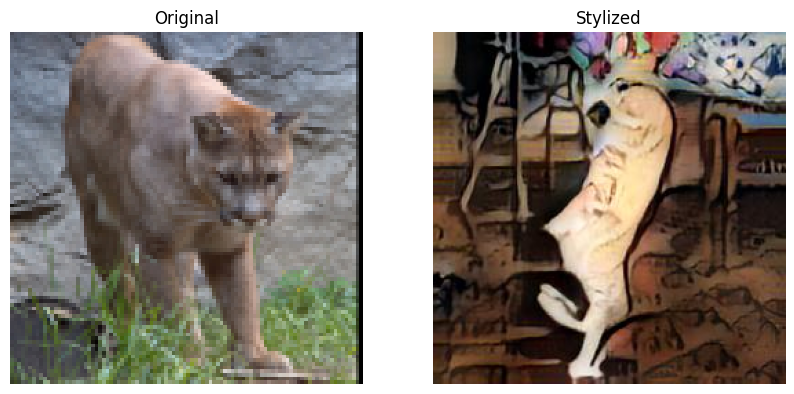

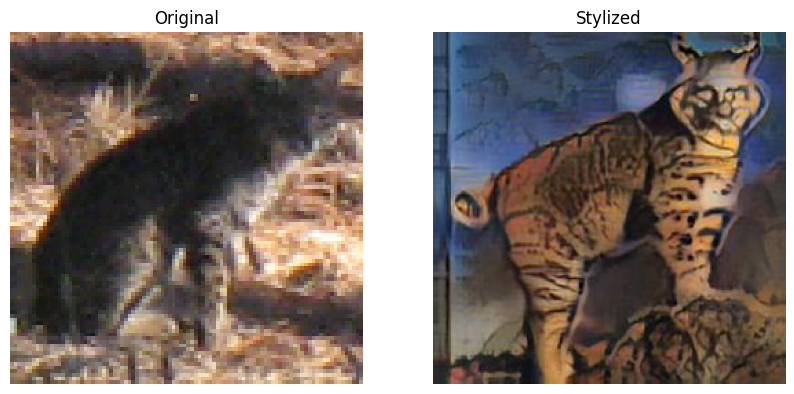

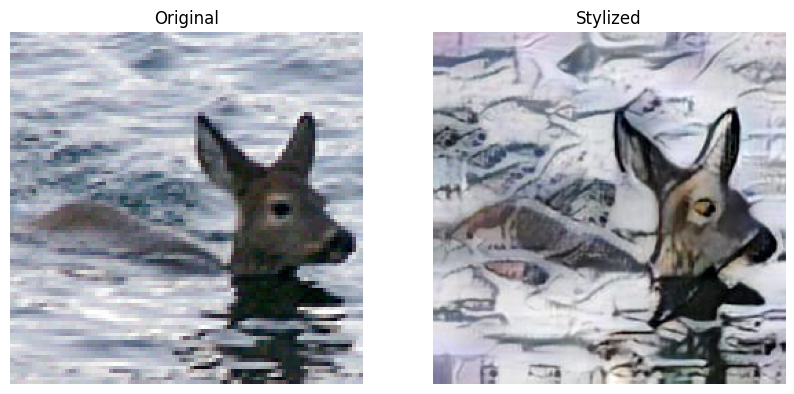

In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

content_dir = '/kaggle/working/content/' 
output_dir = '/kaggle/working/pytorch-AdaIN/output/'  

content_files = sorted([f for f in os.listdir(content_dir) if f.endswith(('.png', '.jpg'))])
output_files = sorted([f for f in os.listdir(output_dir) if f.endswith(('.png', '.jpg'))])

random_indices = random.sample(range(len(content_files)), 5)

for idx in random_indices:
    orig_file = content_files[idx]
    stylized_file = output_files[idx]
    
    orig_img = Image.open(os.path.join(content_dir, orig_file))
    stylized_img = Image.open(os.path.join(output_dir, stylized_file))
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(stylized_img)
    plt.title("Stylized")
    plt.axis('off')
    
    plt.show()


In [8]:
import torch
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 10  

import torchvision.models as models
resnet = models.resnet50(num_classes=num_classes)
resnet.load_state_dict(torch.load('/kaggle/input/my-models/resnet_stl10.pth', map_location=device))
resnet.to(device)
resnet.eval()
print("ResNet loaded!")

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=num_classes)
vit.load_state_dict(torch.load('/kaggle/input/my-models/vit_stl10.pth', map_location=device))
vit.to(device)
vit.eval()
print("ViT (timm) loaded!")


ResNet loaded!
ViT (timm) loaded!


In [9]:
style_to_texture = {
    'asheville.jpg': 0,
}

In [10]:
from torchvision.datasets import STL10

root = '/kaggle/working/stl10'
stl_test = STL10(root=root, split='test', download=True)

stl_test_labels = stl_test.labels  


100%|██████████| 2.64G/2.64G [03:19<00:00, 13.2MB/s] 


In [11]:
texture_labels = [0] * len(stl_test_labels)

shape_labels_expanded = stl_test_labels


In [12]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class StylizedSTL10(Dataset):
    def __init__(self, img_dir, shape_labels, texture_labels, transform=None):
        self.img_dir = img_dir
        self.files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg'))])
        self.shape_labels = shape_labels
        self.texture_labels = texture_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        shape_label = self.shape_labels[idx]
        texture_label = self.texture_labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, shape_label, texture_label

transform_eval = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

stylized_dataset = StylizedSTL10('/kaggle/working/pytorch-AdaIN/output/', stl_test_labels, texture_labels, transform_eval)
stylized_loader = torch.utils.data.DataLoader(stylized_dataset, batch_size=32, shuffle=False)


In [13]:
import torch

def compute_shape_bias(model, loader, device='cuda'):
 
    model.to(device)
    model.eval()
    shape_count = 0
    counted = 0
    
    with torch.no_grad():
        for imgs, shape_labels, texture_labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu()
            
            for i in range(len(preds)):
                pred = preds[i].item()
                shape = shape_labels[i].item()
                texture = texture_labels[i].item()
                
                if pred == shape or pred == texture:
                    counted += 1
                    if pred == shape:
                        shape_count += 1
    
    shape_bias_percent = (shape_count / counted) * 100 if counted > 0 else 0
    return shape_bias_percent


In [18]:
resnet_shape_bias = compute_shape_bias(resnet, stylized_loader)
vit_shape_bias = compute_shape_bias(vit, stylized_loader)

print("ResNet Shape Bias (%) =", resnet_shape_bias)
print("viT Shape Bias (%) =", vit_shape_bias)


ResNet Shape Bias (%) = 32.47172859450727
viT Shape Bias (%) = 53.2587228439763


Feature Representation Analysis

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
from torchvision.models import resnet50
from timm import create_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


In [18]:
transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

root = '/kaggle/working/stl10'
stl_test = STL10(root=root, split='test', download=True, transform=transform_eval)
test_loader = DataLoader(stl_test, batch_size=32, shuffle=False)

img_dir = '/kaggle/working/pytorch-AdaIN/output/'
stylized_loader = DataLoader(StylizedSTL10(img_dir, stl_test.labels, texture_labels, transform_eval), batch_size=32, shuffle=False)


In [24]:
import torch.nn as nn

resnet_feat_extractor = nn.Sequential(*list(resnet.children())[:-1]) 

def extract_resnet_features(x):
    feat = resnet_feat_extractor(x)      
    return feat.flatten(1)               

def extract_vit_features(x):
    feat = vit.forward_features(x)      
    if feat.ndim == 3:
        # Take CLS token
        feat = feat[:, 0, :]          
    return feat
       


In [25]:
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset

def subset_loader(loader, max_samples=500):
    imgs_list, lbls_list = [], []
    count = 0
    for batch in loader:
        imgs = batch[0]
        lbls = batch[1]  
        imgs_list.append(imgs)
        lbls_list.append(lbls)
        
        count += imgs.size(0)
        if count >= max_samples:
            break
    
    imgs_subset = torch.cat(imgs_list)[:max_samples]
    lbls_subset = torch.cat(lbls_list)[:max_samples]
    return torch.utils.data.TensorDataset(imgs_subset, lbls_subset)


normal_subset = subset_loader(test_loader, max_samples=500)
stylized_subset = subset_loader(stylized_loader, max_samples=500)

combined_loader = DataLoader(ConcatDataset([normal_subset, stylized_subset]), batch_size=32)


In [26]:
import numpy as np

def extract_features(loader, model_type='resnet'):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            lbls = lbls.cpu().numpy()
            
            if model_type == 'resnet':
                feats = extract_resnet_features(imgs).cpu().numpy()
            elif model_type == 'vit':
                feats = extract_vit_features(imgs).cpu().numpy()
            
            all_features.append(feats)
            all_labels.append(lbls)
    
    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)

resnet_features, resnet_labels = extract_features(combined_loader, 'resnet')
vit_features, vit_labels = extract_features(combined_loader, 'vit')


In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')

resnet_tsne = tsne.fit_transform(resnet_features)
vit_tsne = tsne.fit_transform(vit_features)


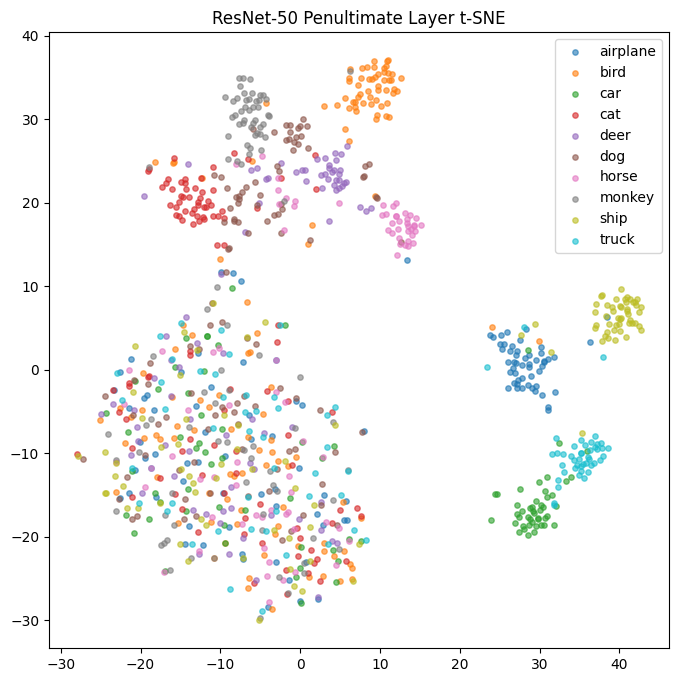

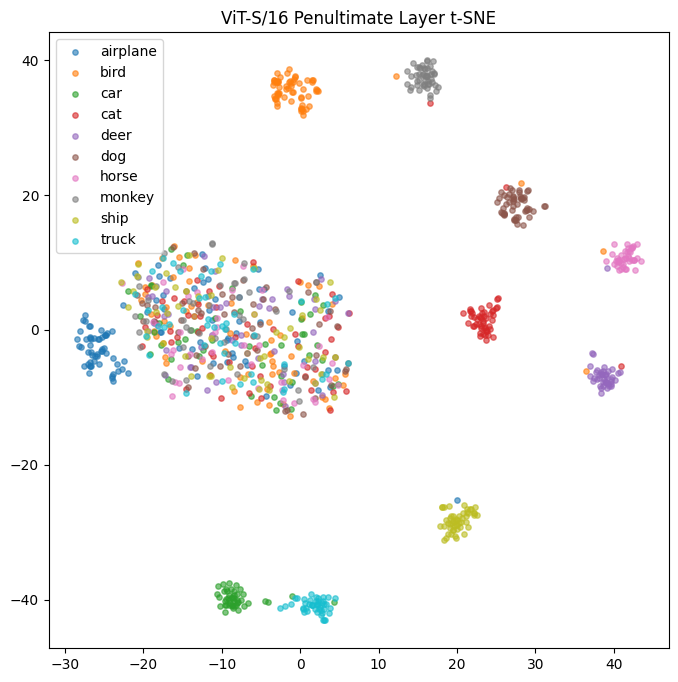

In [59]:
import matplotlib.pyplot as plt
import numpy as np

stl10_classes = [
    'airplane', 'bird', 'car', 'cat', 'deer',
    'dog', 'horse', 'monkey', 'ship', 'truck'
]

def plot_embeddings(embeddings, labels, class_names, title):
    plt.figure(figsize=(8,8))
    unique_labels = np.unique(labels)
    for cls in unique_labels:
        idx = labels == cls
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=class_names[cls], alpha=0.6, s=15)
    plt.legend()
    plt.title(title)
    plt.show()

# Example usage
plot_embeddings(resnet_tsne, resnet_labels, stl10_classes, "ResNet-50 Penultimate Layer t-SNE")
plot_embeddings(vit_tsne, vit_labels, stl10_classes, "ViT-S/16 Penultimate Layer t-SNE")


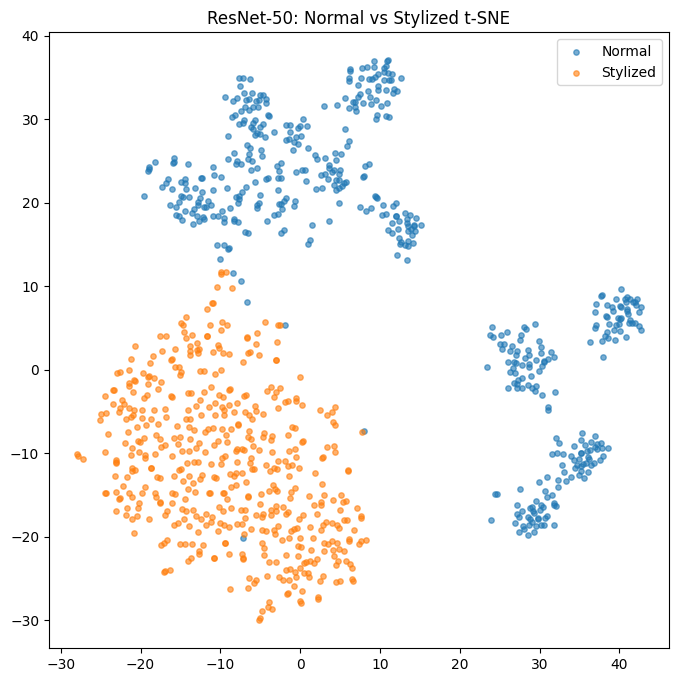

In [29]:
style_labels = np.array([0]*500 + [1]*500)  

plt.figure(figsize=(8,8))
for s in [0,1]:
    idx = style_labels == s
    plt.scatter(resnet_tsne[idx,0], resnet_tsne[idx,1], label=('Normal' if s==0 else 'Stylized'), alpha=0.6, s=15)
plt.legend()
plt.title("ResNet-50: Normal vs Stylized t-SNE")
plt.show()


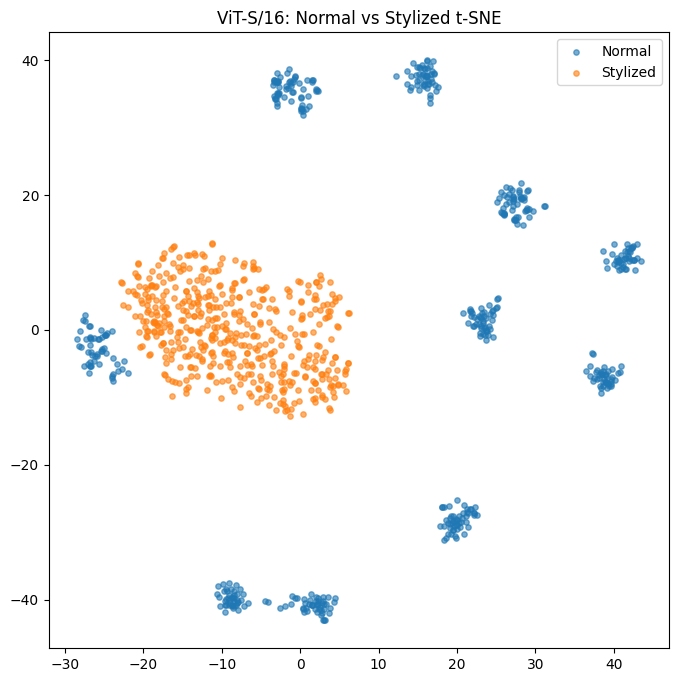

In [30]:
plt.figure(figsize=(8,8))
for s in [0,1]:
    idx = style_labels == s
    plt.scatter(vit_tsne[idx,0], vit_tsne[idx,1], label=('Normal' if s==0 else 'Stylized'), alpha=0.6, s=15)
plt.legend()
plt.title("ViT-S/16: Normal vs Stylized t-SNE")
plt.show()


Domain Generalization Test on PACS

In [42]:
import os
import shutil
from datasets import load_dataset
from PIL import Image

name2domain = {
    "art_painting": "A",
    "cartoon": "C",
    "photo": "P",
    "sketch": "S"
}

hf = load_dataset("flwrlabs/pacs", split="train")

base = "/kaggle/working/pacs-dataset/PACS"

if os.path.exists(base):
    shutil.rmtree(base)
    print(" Removed old PACS directory")

for d in name2domain.values():
    os.makedirs(os.path.join(base, d), exist_ok=True)

print(" Exporting PACS images with proper domain names...")
for idx, item in enumerate(hf):
    domain = name2domain[item["domain"]]
    label = str(item["label"])
    img = item["image"].convert("RGB")

    class_dir = os.path.join(base, domain, label)
    os.makedirs(class_dir, exist_ok=True)

    img.save(os.path.join(class_dir, f"{idx}.jpg"))

    if idx % 2000 == 0:
        print(f"   → {idx} images processed...")

print(f" PACS dataset prepared in DomainBed format at: {base}")


 Exporting PACS images with proper domain names...
   → 0 images processed...
   → 2000 images processed...
   → 4000 images processed...
   → 6000 images processed...
   → 8000 images processed...
 PACS dataset prepared in DomainBed format at: /kaggle/working/pacs-dataset/PACS


In [44]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

base_dir = "/kaggle/working/pacs-dataset/PACS"  

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_domains = ['A','C','P']
train_datasets = [datasets.ImageFolder(os.path.join(base_dir,d), transform=train_transform) for d in train_domains]
train_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(os.path.join(base_dir,'S'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [45]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 7  


In [46]:
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
vit = vit.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s] 


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [47]:
from tqdm import tqdm

def train_model(model, loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            loop.set_postfix(loss=total_loss/((loop.n+1)))  



In [48]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    loop = tqdm(loader, desc="Evaluating")
    with torch.no_grad():
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(acc=correct/total*100)
    acc = correct / total * 100
    return acc


In [52]:
print("Training ResNet-50...")
train_model(resnet, train_loader, epochs=5, lr=5e-5)
resnet_acc = evaluate(resnet, test_loader)
print(f"ResNet-50 Accuracy on Sketch: {resnet_acc:.2f}%")

Training ResNet-50...


Evaluating: 100%|██████████| 123/123 [00:18<00:00,  6.73it/s, acc=56.8]

ResNet-50 Accuracy on Sketch: 56.76%


In [55]:
from tqdm import tqdm

def train_vit(model, loader, epochs=5, lr=5e-5, weight_decay=0.05, freeze_patch_embed=False):
    if freeze_patch_embed:
        for param in model.patch_embed.parameters():
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=total_loss/((loop.n+1)))


In [56]:
print("Training ViT-S/16...")
train_vit(vit, train_loader, epochs=5, lr=5e-5)
vit_acc = evaluate(vit, test_loader)
print(f"ViT-S/16 Accuracy on Sketch: {vit_acc:.2f}%")

Training ViT-S/16...


Evaluating: 100%|██████████| 123/123 [00:19<00:00,  6.39it/s, acc=55.9]

ViT-S/16 Accuracy on Sketch: 55.87%


In [60]:
print("Training ViT-S/16...")
train_vit(vit, train_loader, epochs=10, lr=5e-5)
vit_acc = evaluate(vit, test_loader)
print(f"ViT-S/16 Accuracy on Sketch: {vit_acc:.2f}%")

Training ViT-S/16...


Evaluating: 100%|██████████| 123/123 [00:19<00:00,  6.42it/s, acc=56.7]

ViT-S/16 Accuracy on Sketch: 56.73%
